In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def cal_true_num(task="chest"):
    
    with open(f"data/medfmc/data_backup/{task}_test_WithLabel.txt", "r") as file:
        data = file.readlines()

    # print(data)

    print(f"Number of data points: {len(data)}")
    
    if task == "chest":
        num_class = 19
    elif task == "endo":
        num_class = 4

    num_pos = np.array([0 for i in range(num_class)])

    print(num_pos)

    for d in data:
        if task == "chest":
            num_pos += np.array(d.strip('\n').split(" ")[-1].split(',')).astype(int)
        elif task == "endo":
            num_pos += np.array(d.strip('\n').split(" ")[1:]).astype(int)

    print(num_pos)
    
    num_pos = num_pos.sum()
    
    # print(num_pos)
    
    num_total = len(data)*num_class
    
    num_neg = num_total - num_pos
    
    return num_total, num_pos, num_neg

In [3]:
cal_true_num("chest")

Number of data points: 1161
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[428 199 273 271 224 161 212 141 151 157 124 136  44  93  35  20  13   4
  12]


(22059, 2698, 19361)

In [4]:
cal_true_num("endo")

Number of data points: 881
[0 0 0 0]
[196 222  69   0]


(3524, 487, 3037)

In [5]:
def evaluate(task="chest"):
    
    print(f"Task: {task}")
    
    directory = f"work_dirs/densenet121_4xb256_in1k-{task}/"
    
    result_folder_list = os.listdir(directory)
    result_folder_list = [i for i in result_folder_list if '.' not in i]
    result_folder_list.remove("last_checkpoint")
    
    print(result_folder_list)
    
    epoch_list = []
    acc_list = []
    map_list = []
    
    if task in ["chest", "endo"]:
        num_total, num_pos, num_neg = cal_true_num(task)
    
    for folder in result_folder_list:
        
        print(folder)
        
        result_file_list = os.listdir(f"work_dirs/densenet121_4xb256_in1k-{task}/{folder}/")
        
        
        result_json = [i for i in result_file_list if i[-len("json"):]=="json"]
        if len(result_json) == 0:
            continue
        elif len(result_json) == 1:
            result_json  = result_json[0]
            print(result_json)
        else:
            print("?????????????????????????")
            
            
        result_log = [i for i in result_file_list if i[-len("log"):]=="log"][0]
        with open(f"work_dirs/densenet121_4xb256_in1k-{task}/{folder}/{result_log}", 'r') as file:
            result_log = file.readlines()
        epoch_list.append(int(result_log[-2].split(' ')[-1].split('/')[-1].replace('epoch_', '').replace('.pth\n', '')))
            
            
        if task in ["chest", "endo"]:
            
            with open(f"work_dirs/densenet121_4xb256_in1k-{task}/{folder}/{result_json}", "r") as file:
                result_dict = json.load(file)

#             print(result_dict)

            precision = result_dict["multi-label/precision_micro"]*0.01
            recall =  result_dict["multi-label/recall_micro"]*0.01

            label_1_1 = round(num_pos * recall)
            label_1_0 = round(num_pos * (1 - recall))

            if precision < 1e-4:
                assert recall == 0, f"Wrong Calculation {recall}"
                assert label_1_1 == 0, f"Wrong Calculation {label_1_1}"
                label_0_1 = 0
            else:
                label_0_1 = round(label_1_1 / precision) - label_1_1
            label_0_0 = num_neg - label_0_1

            assert (num_total - label_0_1 - label_1_0 - label_1_1) == label_0_0, f"Wrong calculation of label_0_0 {(num_total - label_0_1 - label_1_0 - label_1_1)} {label_0_0}"

            print(f"\nnum_total: {num_total}\nnum_pos: {num_pos}\nnum_neg: {num_neg}\n")
            print(f"\nprecision: {precision}\nrecall: {recall}\n")
            print(np.array([[label_0_0, label_0_1], [label_1_0, label_1_1]]))
            print(f"\n****************************** Accuracy: {(label_0_0 + label_1_1) / num_total} ******************************\n")
            
            acc_list.append((label_0_0 + label_1_1) / num_total * 100)
            map_list.append(result_dict["multi-label/mAP"])
            
            
            
            
        elif task == "colon":
            with open(f"work_dirs/densenet121_4xb256_in1k-{task}/{folder}/{result_json}", "r") as file:
                result_dict = json.load(file)
            
#             print(result_dict)
            print(f"\n****************************** Accuracy: {result_dict['accuracy/top1']} ******************************\n")
            
            acc_list.append(result_dict['accuracy/top1'])
            map_list.append(result_dict["multi-label/mAP"])
    
    
    df_acc = pd.DataFrame({'Epochs': epoch_list, f"Accuracy (%)": acc_list})
    epoch = 0
    while True:
        if epoch+10 < df_acc.index.values[-1]:
            display(df_acc.T.loc[:, epoch:epoch+9])
            epoch += 10
        else:
            display(df_acc.T.loc[:, epoch:])
            break
    plt.figure(figsize=(15,8))
    ax = sns.lineplot(data=df_acc, x='Epochs', y="Accuracy (%)")
    plt.title(f"Metrics over epochs -- {task.upper()}") # , fontsize=
    plt.xlabel('Epochs')
    plt.ylabel(f"Accuracy (%)")
    
    df_map = pd.DataFrame({'Epochs': epoch_list, f"mAP (%)": map_list})
    epoch = 0
    while True:
        if epoch+10 < df_map.index.values[-1]:
            display(df_map.T.loc[:, epoch:epoch+9])
            epoch += 10
        else:
            display(df_map.T.loc[:, epoch:])
            break
    plt.figure(figsize=(15,8))
    ax = sns.lineplot(data=df_map, x='Epochs', y="mAP (%)")
    plt.title(f"Metrics over epochs -- {task.upper()}") # , fontsize=
    plt.xlabel('Epochs')
    plt.ylabel(f"mAP (%)")

Task: chest
['20240601_225044', '20240601_232854', '20240601_232908', '20240601_232919', '20240601_232929', '20240601_232939', '20240601_232950', '20240601_233000', '20240601_233011', '20240601_233021', '20240601_233032', '20240601_233042', '20240601_233053', '20240601_233104', '20240601_233114', '20240601_233125', '20240601_233135', '20240601_233146', '20240601_233157', '20240601_233207', '20240601_233218', '20240601_233228', '20240601_233239', '20240601_233249', '20240601_233300', '20240601_233311', '20240601_233321', '20240601_233332', '20240601_233343', '20240601_233353', '20240601_233404', '20240601_233414', '20240601_233424', '20240601_233435', '20240601_233446', '20240601_233457', '20240601_233508', '20240601_233518', '20240601_233529', '20240601_233539', '20240601_233550']
Number of data points: 1161
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[428 199 273 271 224 161 212 141 151 157 124 136  44  93  35  20  13   4
  12]
20240601_225044
20240601_232854
20240601_232854.json

num_tot

,0,1,2,3,4,5,6,7,8,9
Epochs,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000
Accuracy (%),84.981187,83.965728,82.904937,81.744413,84.292126,87.855297,87.329435,87.823564,87.787298,87.791831


,10,11,12,13,14,15,16,17,18,19
Epochs,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
Accuracy (%),87.769165,87.755565,80.116959,87.583299,87.769165,87.796364,87.819031,87.773698,87.796364,87.800898


,20,21,22,23,24,25,26,27,28,29
Epochs,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000,27.000000,28.000000,29.000000,30.000000
Accuracy (%),87.819031,87.769165,87.787298,87.800898,87.723832,87.755565,87.769165,87.769165,87.760098,87.755565


,30,31,32,33,34,35,36,37,38,39
Epochs,31.000000,32.000000,33.000000,34.000000,35.000000,36.000000,37.000000,38.000000,39.000000,40.000000
Accuracy (%),87.755565,87.782764,87.782764,87.769165,87.769165,87.787298,87.782764,87.773698,87.782764,87.796364


,0,1,2,3,4,5,6,7,8,9
Epochs,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000
mAP (%),12.573421,12.573421,12.573421,13.283751,13.751274,14.657921,14.285311,14.482939,14.521459,14.523382


,10,11,12,13,14,15,16,17,18,19
Epochs,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.00000,19.00000,20.000000
mAP (%),14.540534,14.846272,12.936219,14.116139,14.064143,14.100289,13.757742,13.93808,13.76952,14.492258


,20,21,22,23,24,25,26,27,28,29
Epochs,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000,27.000000,28.000000,29.000000,30.000000
mAP (%),14.666788,14.334102,14.977002,15.096561,15.410521,15.706059,15.615019,15.734534,16.073038,15.949458


,30,31,32,33,34,35,36,37,38,39
Epochs,31.000000,32.000000,33.000000,34.000000,35.000000,36.000000,37.000000,38.000000,39.000000,40.00000
mAP (%),16.157623,16.121542,16.121632,16.278452,16.392664,16.567955,16.427958,16.551165,16.515224,16.51104


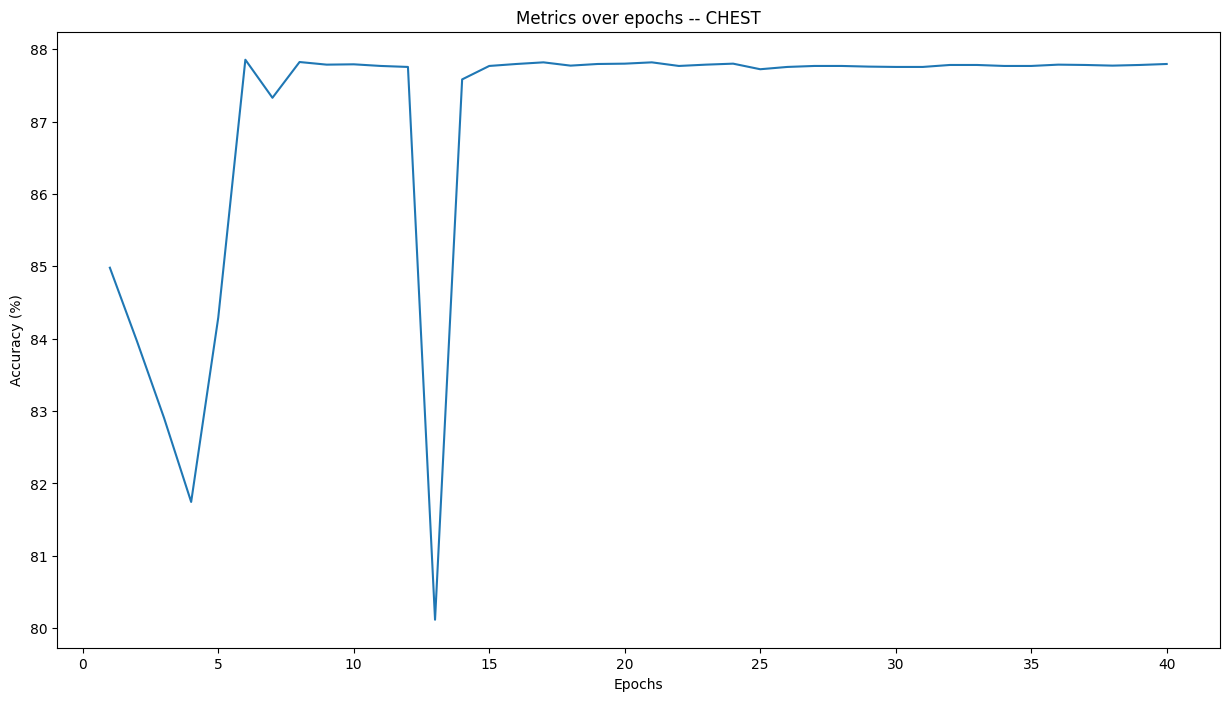

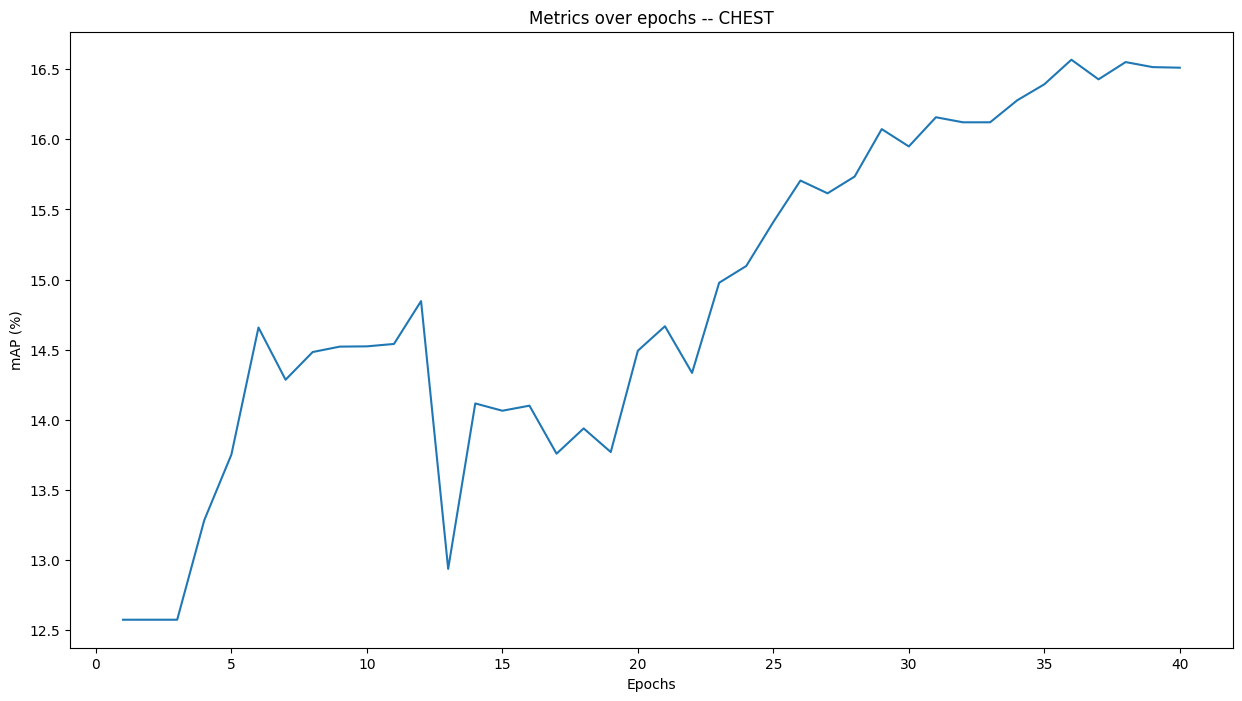

In [6]:
evaluate(task="chest")

Task: colon
['20240603_195254', '20240603_202316', '20240603_202339', '20240603_202403', '20240603_202429', '20240603_202456', '20240603_202523', '20240603_202552', '20240603_202618', '20240603_202645', '20240603_202709', '20240603_202737', '20240603_202804', '20240603_202834', '20240603_202858', '20240603_202925', '20240603_202952', '20240603_203019', '20240603_203043', '20240603_203112', '20240603_203142', '20240603_203208', '20240603_203232', '20240603_203257', '20240603_203322', '20240603_203349', '20240603_203415', '20240603_203444', '20240603_203510', '20240603_203536', '20240603_203559', '20240603_203619', '20240603_203642', '20240603_203705', '20240603_203726', '20240603_203749', '20240603_203813', '20240603_203836', '20240603_203856', '20240603_203917', '20240603_203941']
20240603_195254
20240603_202316
20240603_202316.json

****************************** Accuracy: 30.339805603027344 ******************************

20240603_202339
20240603_202339.json

************************

,0,1,2,3,4,5,6,7,8,9
Epochs,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.00000,8.000000,9.000000,10.000000
Accuracy (%),30.339806,30.339806,78.033981,74.302185,65.776695,70.054611,81.58374,82.736649,84.192963,80.430824


,10,11,12,13,14,15,16,17,18,19
Epochs,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
Accuracy (%),85.072815,84.799759,84.921112,87.105583,83.525482,87.985435,87.105583,87.803398,85.983009,87.651695


,20,21,22,23,24,25,26,27,28,29
Epochs,21.00000,22.000000,23.000000,24.000000,25.000000,26.000000,27.000000,28.000000,29.000000,30.000000
Accuracy (%),87.16626,85.740288,86.589806,86.589806,84.010918,83.495148,86.984222,87.257278,86.529121,83.282768


,30,31,32,33,34,35,36,37,38,39
Epochs,31.000000,32.000000,33.000000,34.000000,35.000000,36.000000,37.000000,38.000000,39.000000,40.000000
Accuracy (%),86.438103,86.680824,87.135918,87.014565,86.438103,87.591019,86.620148,67.688103,87.378639,87.075241


,0,1,2,3,4,5,6,7,8,9
Epochs,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000
mAP (%),53.143806,52.919178,75.726463,74.686829,70.721695,83.839401,89.017982,87.947906,90.999969,82.603943


,10,11,12,13,14,15,16,17,18,19
Epochs,11.00000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
mAP (%),89.10437,87.636604,89.794067,91.373619,89.204742,90.864365,90.437767,91.276642,90.566765,91.292503


,20,21,22,23,24,25,26,27,28,29
Epochs,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000,27.000000,28.000000,29.000000,30.000000
mAP (%),92.290344,91.703728,91.183273,91.364182,90.266403,91.020294,92.046608,89.419434,92.184135,90.259575


,30,31,32,33,34,35,36,37,38,39
Epochs,31.000000,32.000000,33.000000,34.000000,35.000000,36.000000,37.000000,38.000000,39.000000,40.000000
mAP (%),91.350349,91.827606,92.289284,91.849098,92.156342,92.550148,92.342773,87.040237,92.817657,93.323318


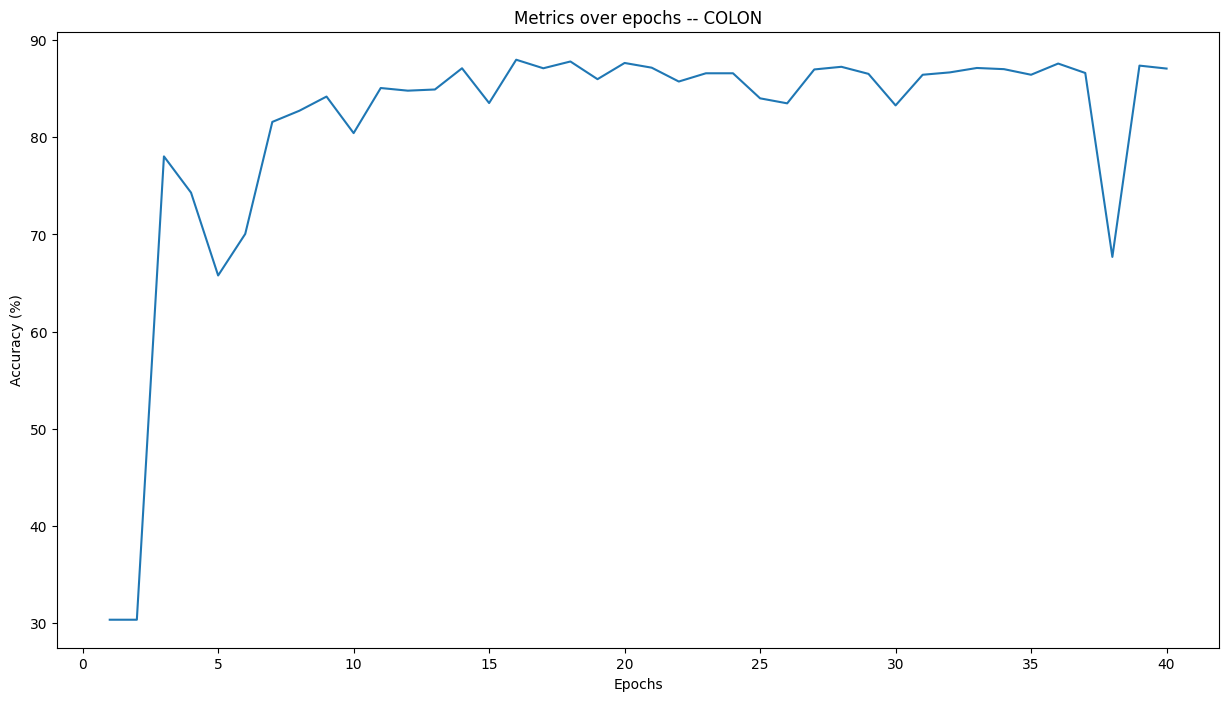

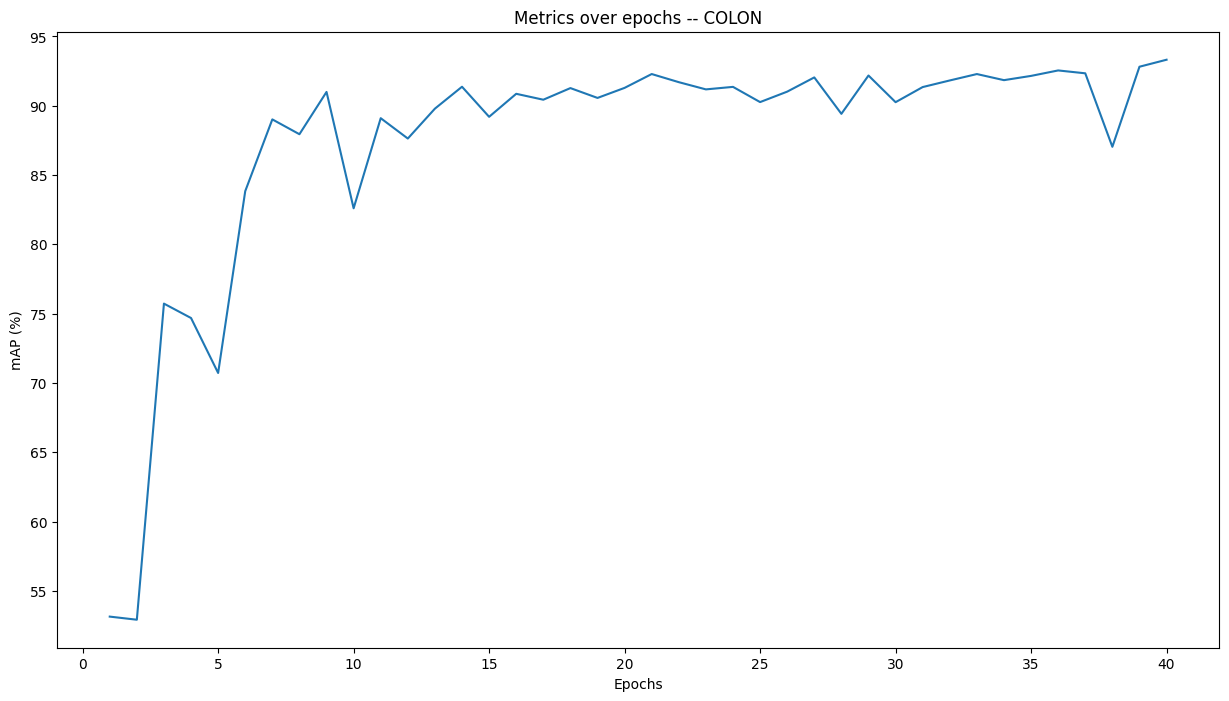

In [8]:
evaluate(task="colon")

Task: endo
['20240601_231846', '20240601_234845', '20240601_234857', '20240601_234907', '20240601_234917', '20240601_234927', '20240601_234937', '20240601_234947', '20240601_234957', '20240601_235007', '20240601_235017', '20240601_235027', '20240601_235038', '20240601_235048', '20240601_235058', '20240601_235108', '20240601_235118', '20240601_235128', '20240601_235138', '20240601_235148', '20240601_235158', '20240601_235208', '20240601_235219', '20240601_235229', '20240601_235239', '20240601_235249', '20240601_235259', '20240601_235309', '20240601_235319', '20240601_235330', '20240601_235340', '20240601_235350', '20240601_235400', '20240601_235410', '20240601_235420', '20240601_235430', '20240601_235440', '20240601_235450', '20240601_235500', '20240601_235511', '20240601_235521']
Number of data points: 881
[0 0 0 0]
[196 222  69   0]
20240601_231846
20240601_234845
20240601_234845.json

num_total: 3524
num_pos: 487
num_neg: 3037


precision: 0.0
recall: 0.0

[[3037    0]
 [ 487    0]]


,0,1,2,3,4,5,6,7,8,9
Epochs,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.0000,9.000000,10.000000
Accuracy (%),86.180477,86.180477,86.180477,86.180477,86.180477,77.951192,76.475596,86.1521,85.414302,70.856981


,10,11,12,13,14,15,16,17,18,19
Epochs,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.00000
Accuracy (%),81.696935,85.385925,84.704881,84.875142,85.839955,85.329171,85.244041,85.045403,85.385925,85.15891


,20,21,22,23,24,25,26,27,28,29
Epochs,21.000000,22.000000,23.000000,24.000000,25.000000,26.000000,27.000000,28.000000,29.000000,30.000000
Accuracy (%),82.548241,82.690125,81.299659,83.910329,85.442679,83.484677,83.569807,84.335982,84.279228,83.967083


,30,31,32,33,34,35,36,37,38,39
Epochs,31.000000,32.000000,33.000000,34.00000,35.000000,36.000000,37.000000,38.000000,39.000000,40.000000
Accuracy (%),84.591373,84.704881,84.704881,84.53462,83.938706,84.137344,84.477866,84.477866,84.506243,84.335982


,0,1,2,3,4,5,6,7,8,9
Epochs,1.00000,2.00000,3.00000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000
mAP (%),14.43484,14.43484,14.43484,14.596321,14.024838,16.058998,13.407969,14.762826,15.267248,15.060509


,10,11,12,13,14,15,16,17,18,19
Epochs,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
mAP (%),16.576416,15.556373,14.317332,14.446038,15.906487,15.957546,15.858939,16.274971,16.533228,16.152714


,20,21,22,23,24,25,26,27,28,29
Epochs,21.000000,22.000000,23.000000,24.000000,25.00000,26.00000,27.000000,28.000000,29.000000,30.000000
mAP (%),15.539562,15.658037,16.804926,16.263176,17.73926,15.46962,16.920631,15.815614,15.825327,16.548336


,30,31,32,33,34,35,36,37,38,39
Epochs,31.000000,32.000000,33.000000,34.000000,35.000000,36.000000,37.000000,38.000000,39.000000,40.000000
mAP (%),16.516205,16.754786,16.481222,16.620289,16.739828,16.674515,16.723772,16.682034,16.705069,16.709507


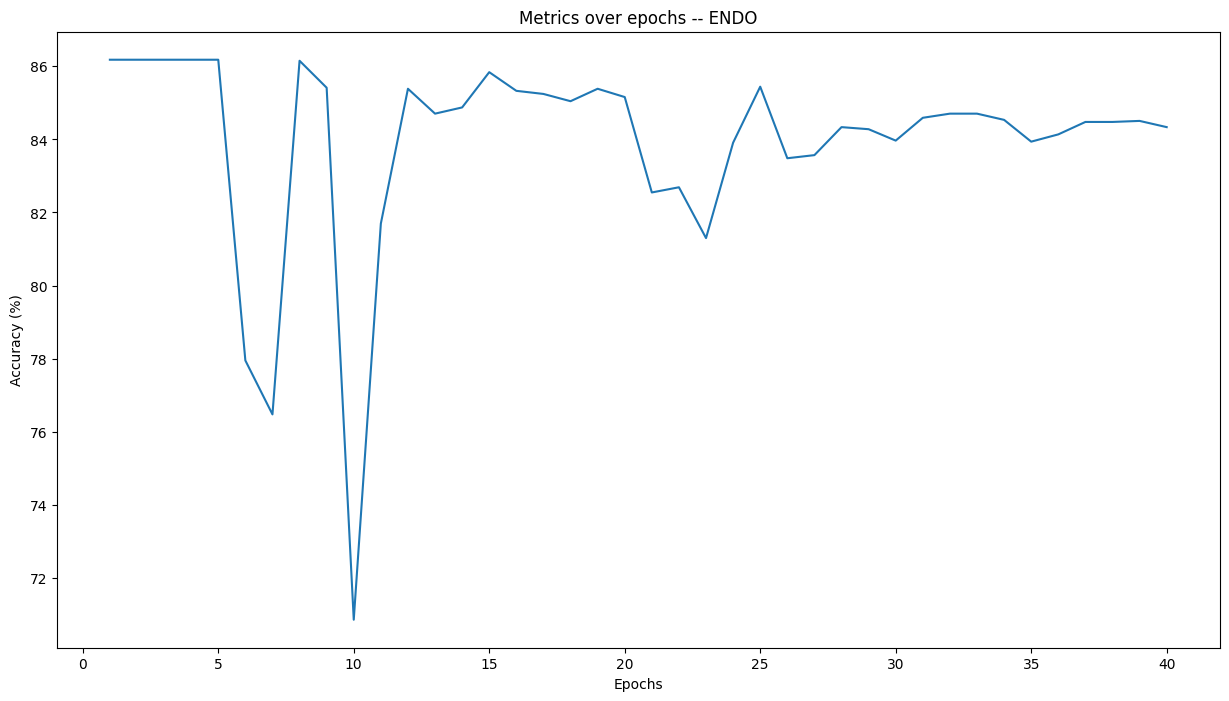

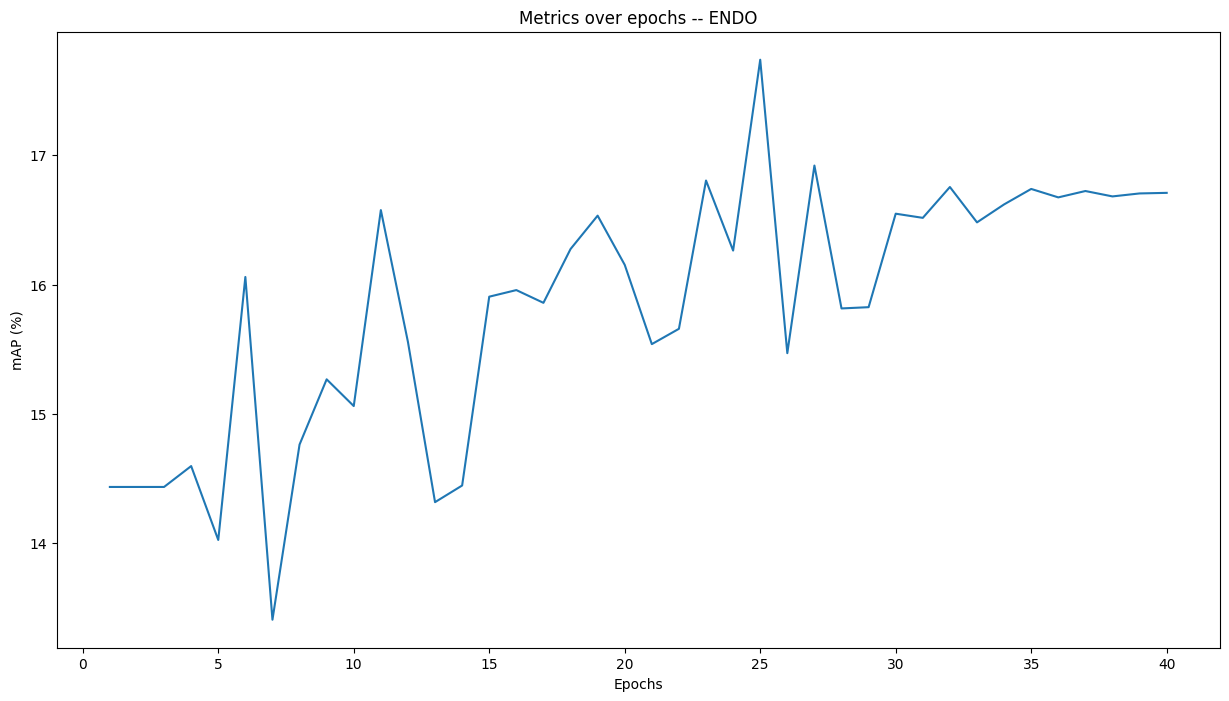

In [7]:
evaluate(task="endo")

In [9]:
for i in ["DX.1.2.392.200046.100.2.1.69131194618.191116084230.1.1.1.png", "5E0028D65D00B3A.png", "5D0984CC1D7C36B.png", "CR.1.3.12.2.1107.5.3.57.20200.11.201910300851500343.png", "5B91F7409CCCE2.png", "5CB12B9D24ECD3C.png"]:
    print(i in pd.read_csv("data/medfmc/MedFMC/chest/chest_train.csv")['img_id'].values)

True
True
True
True
True
False


In [10]:
for i in ["DX.1.2.392.200046.100.2.1.69131194618.191116084230.1.1.1.png", "5E0028D65D00B3A.png", "5D0984CC1D7C36B.png", "CR.1.3.12.2.1107.5.3.57.20200.11.201910300851500343.png", "5B91F7409CCCE2.png", "5CB12B9D24ECD3C.png"]:
    print(i in pd.read_csv("data/medfmc/MedFMC/chest/chest_val.csv")['img_id'].values)

False
False
False
False
False
True


In [11]:
print(783+196+1161) # 2140
print(783/2140, 196/2140, 1161/2140)

2140
0.3658878504672897 0.09158878504672897 0.5425233644859813


In [12]:
print(1677+681+3296) # 5654
print(1677/5654, 681/5654, 3296/5654)

5654
0.29660417403608064 0.12044570215776441 0.582950123806155


In [13]:
print(743+186+881) # 1810
print(743/1810, 186/1810, 881/1810)

1810
0.41049723756906076 0.10276243093922652 0.4867403314917127


,Category,Num
0,ulcer,196
1,erosion,222
2,polyp,69
3,tumor,0


Text(0.5, 0, 'Instance Type ')

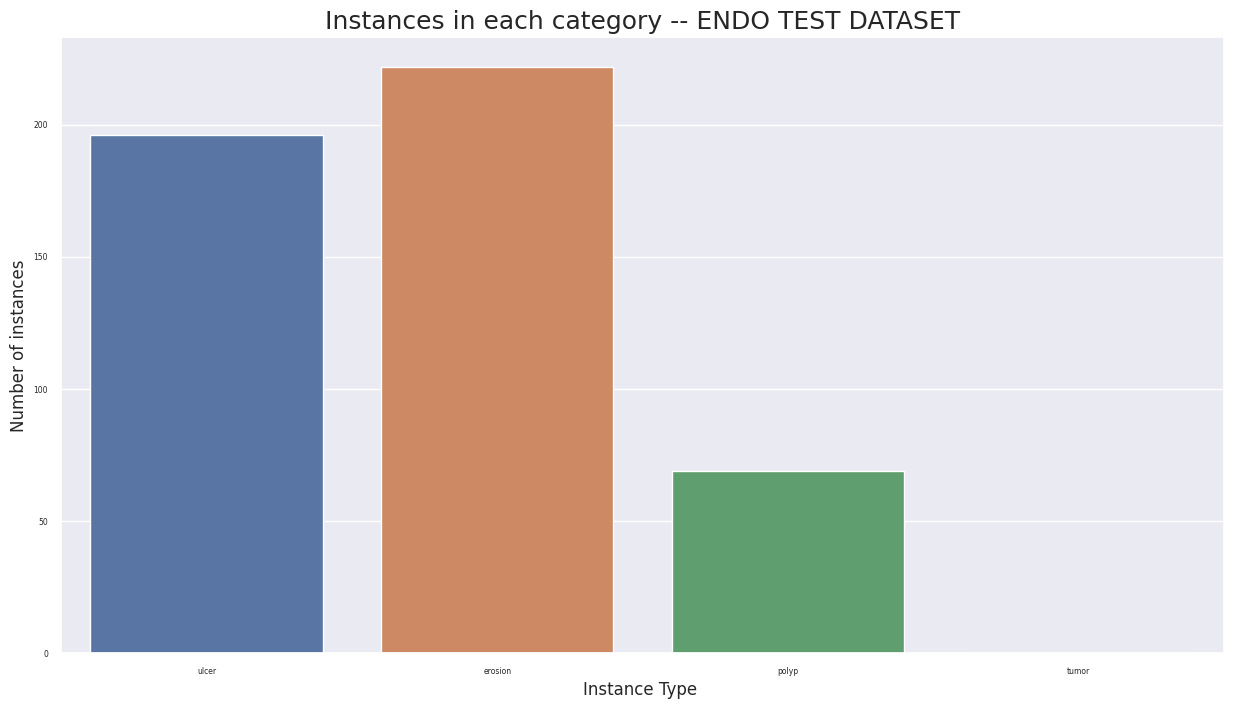

In [18]:
sns.set(font_scale=0.5)
    
plt.figure(figsize=(15,8))

df_tmp = pd.DataFrame({'Category': ['ulcer', 'erosion', 'polyp', 'tumor'], 'Num': [196, 222, 69, 0]})

display(df_tmp)

ax = sns.barplot(data=df_tmp, x='Category', y='Num', hue="Category")

plt.title(f"Instances in each category -- ENDO TEST DATASET", fontsize=18)
plt.ylabel('Number of instances', fontsize=12)
plt.xlabel('Instance Type ', fontsize=12)